The goal of this notebook is to explain text classification with keras.


##About keras:


Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow.
Keras is the high-level API of the TensorFlow platform: an approachable, highly-productive interface for solving machine learning problems, with a focus on modern deep learning.



##Text classification using keras

Reference: https://keras.io/examples/nlp/text_classification_from_scratch/

The goal here is to perform text classification.
Here we will be considering the task of binary classification, thus dividing our text into two classes: **positive and negative.**

Dataset used here:

https://www.kaggle.com/competitions/nlp-getting-started/data

We will be using Disaster tweet data where the text would contain information about disaster ( if the class is 1) and any other text if the class is 0.



In [ ]:
#importing neccessary libraries:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#loading the train and testset:

df_train= pd.read_csv('train.csv')
df_test= pd.read_csv('test.csv')

print('Training data shape = {}'.format(df_train.shape))
print('Test data shape = {}'.format(df_test.shape))

Training data shape = (7613, 5)
Test data shape = (3263, 4)


In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Keywords and location:

We see columns named as keywords and location which have missing values

As we can see that both these columns have almost similar missing values in train and test set, we can assume that the train and test set belong to the same distribution.



In [ ]:
print("Missing values in training set")
print("keyword column: ", (len(df_train[pd.isnull(df_train['keyword'])])/len(df_train))*100, "%")

print("location column: ", (len(df_train[pd.isnull(df_train['location'])])/len(df_train))*100, "%")

print("Missing values in test set")
print("keyword column: ", (len(df_test[pd.isnull(df_test['keyword'])])/len(df_test))*100, "%")
print("location column: ", (len(df_test[pd.isnull(df_test['location'])])/len(df_test))*100, "%")

Missing values in training set
keyword column:  0.8012610009194797 %
location column:  33.27203467752528 %
Missing values in test set
keyword column:  0.796812749003984 %
location column:  33.86454183266932 %


We fill the missing values with "no_keyword" and "no_location"



In [ ]:
for df in[df_train, df_test]:
  for col in ['keyword', 'location']:
    df[col]= df[col].fillna(f'no_{col}')

Class distribution :
Since the classes are almost equally balanced, we dont need to perform any kind of class imbalance handling for this data


In [ ]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

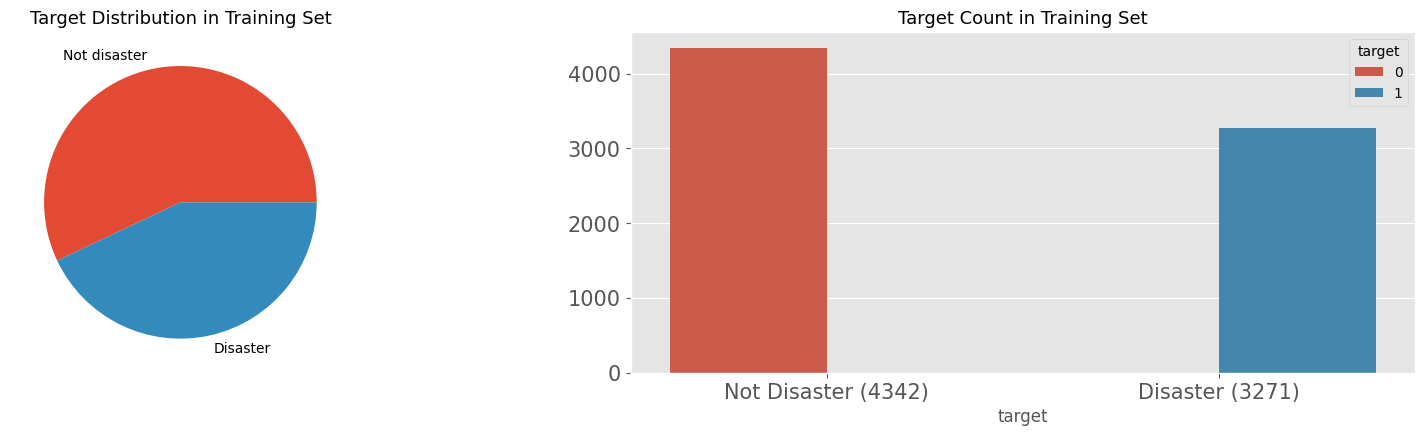

In [ ]:
fig,axes= plt.subplots(ncols=2, figsize=(17,4), dpi=100)
plt.tight_layout()
df_train.groupby('target').count()['id'].plot(kind='pie', ax= axes[0], labels=['Not disaster', 'Disaster'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

###Performing basic EDA on text to do some cleaning and pre processing before training the classifier


1. Average word length in the tweets in both classes

2. Number of words in the tweets

<ipython-input-17-b530e3fcfd7f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
<ipython-input-17-b530e3fcfd7f>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')


Text(0.5, 0.98, 'Average word length in each tweet')

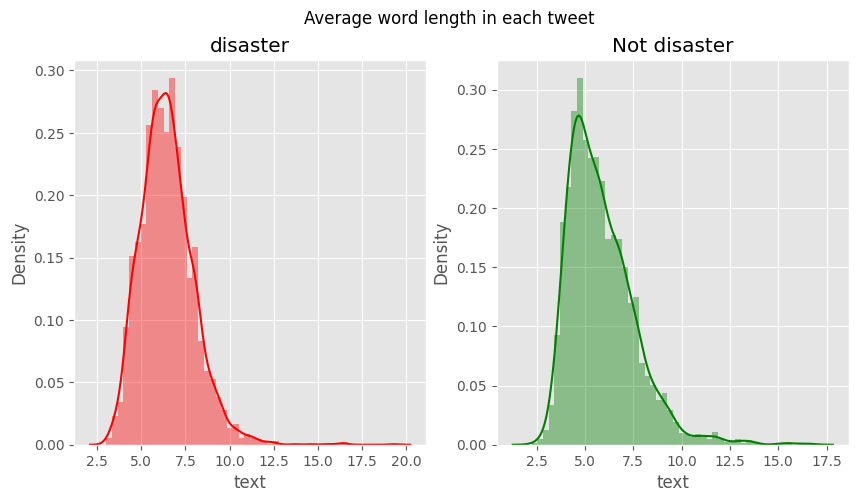

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

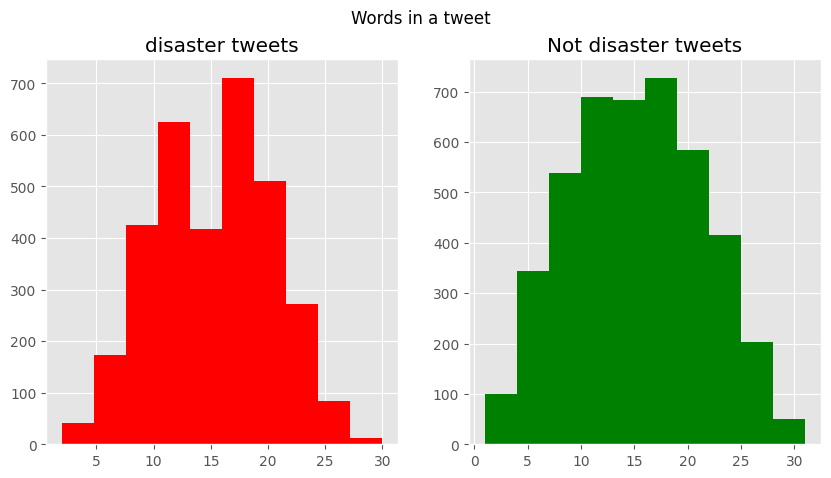

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

3. Finding common words


<Axes: >

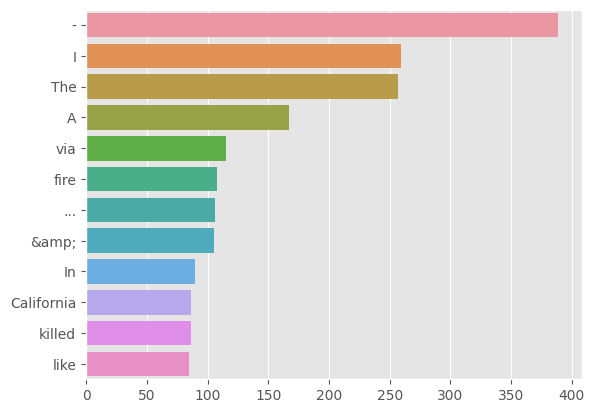

In [ ]:
def create_corpus(target):
    corpus=[]

    for x in df_train[df_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


corpus= create_corpus(1)

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)


sns.barplot(x=y, y=x)

<Axes: >

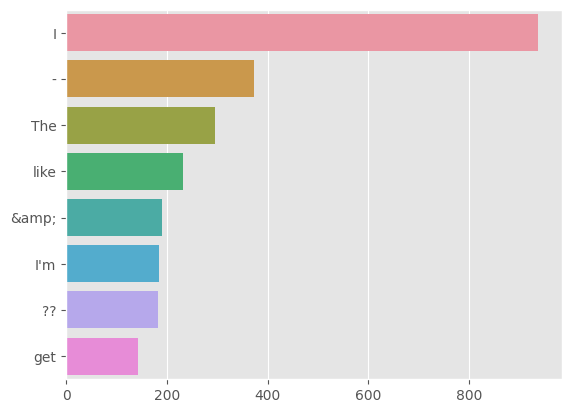

In [ ]:
def create_corpus(df2, target):
    corpus=[]

    for x in df2[df2['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


corpus= create_corpus(df_train, 0)

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)


sns.barplot(x=y, y=x)

With these analysis, we observe that we need to perform cleaning of stopwords, punctuations before passing the data for training.

Also since the train and test data both are from same sample, we perform these cleaning excercises on both training and testing data

###Data cleaning

In [ ]:
df= pd.concat([df_train, df_test])
df.shape

(10876, 5)

In [ ]:
#functions for data cleaning:

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [ ]:
df['text']=df['text'].apply(lambda x : remove_URL(x))
df['text']=df['text'].apply(lambda x : remove_html(x))
df['text']=df['text'].apply(lambda x : remove_emoji(x))
df['text']=df['text'].apply(lambda x : remove_punct(x))


In [ ]:
#removing stop words:
def remove_stopwords(text):
  text_token=  [t for t in text.split() if t not in stop]
  return " ".join(text_token)

df['text']=df['text'].apply(lambda x : remove_stopwords(x))


##Word cloud

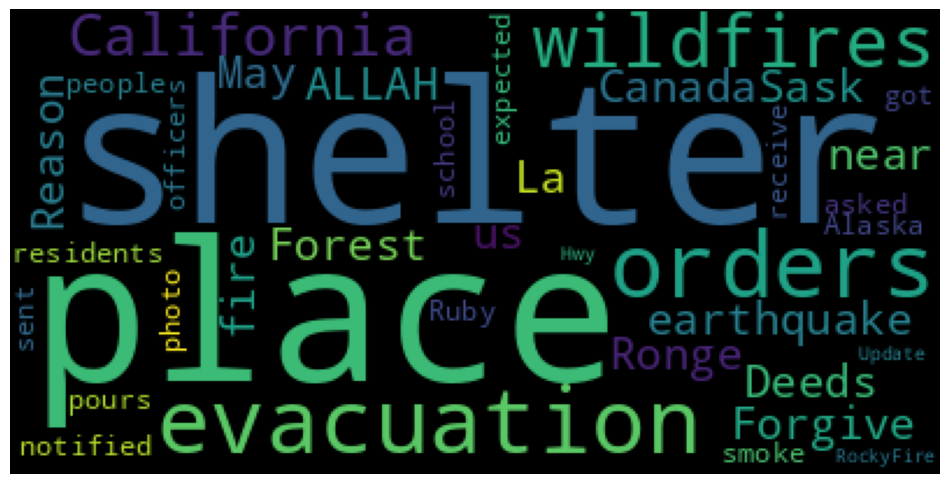

In [ ]:
#creating wordcloud

corpus1= create_corpus(df, 1)

from wordcloud import WordCloud
plt.figure(figsize=(12,8))
word_cloud= WordCloud().generate(" ".join(corpus1[0:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

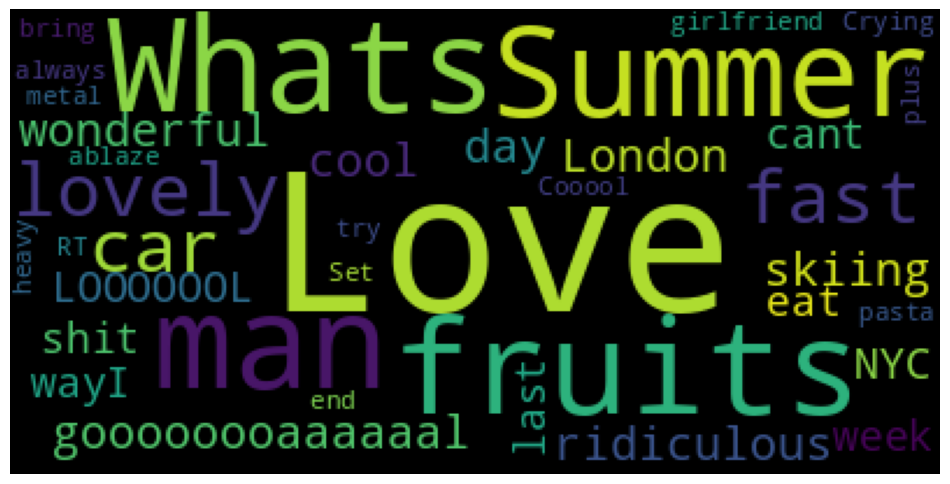

In [ ]:
#creating wordcloud for class 0

corpus1= create_corpus(df, 0)

from wordcloud import WordCloud
plt.figure(figsize=(12,8))
word_cloud= WordCloud().generate(" ".join(corpus1[0:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Once the EDA and data cleaning is done, we would now use our training and test data, and perform classification

In [ ]:
df= df[~(pd.isnull(df['text']))]
df= df[~(pd.isnull(df['target']))]

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y= train_test_split(df.text, df.target, test_size=0.2)
print(train_x.shape, test_x.shape)

(6090,) (1523,)


Now we would perform feature extraction using bag of words and tf idf and compare the results against multiple classification algorithms.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


In [ ]:

count_vect = CountVectorizer()
count_vect.fit(train_x)
#X_train_counts.shape

X_test= count_vect.transform(test_x)
X_train= count_vect.transform(train_x)

Explaining neural networks:

While using neural networks, we first aim to create a model using the Sequential API adding a hidden layer in between and resulting final layer which can give out probabilities.
These neural networks go through a forward pass and a backpropagation step to optimize the loss function and result in final probabilities.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                154580    
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 154,591
Trainable params: 154,591
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train.toarray(), train_y,
                    epochs=20,
                    verbose=True,
                    batch_size=10)

Epoch 1/20
609/609 [==============================] - 4s 7ms/step - loss: 0.5571 - accuracy: 0.7521
Epoch 2/20
609/609 [==============================] - 5s 8ms/step - loss: 0.3114 - accuracy: 0.8867
Epoch 3/20
609/609 [==============================] - 4s 7ms/step - loss: 0.1880 - accuracy: 0.9353
Epoch 4/20
609/609 [==============================] - 3s 4ms/step - loss: 0.1242 - accuracy: 0.9586
Epoch 5/20
609/609 [==============================] - 3s 4ms/step - loss: 0.0933 - accuracy: 0.9678
Epoch 6/20
609/609 [==============================] - 3s 4ms/step - loss: 0.0725 - accuracy: 0.9744
Epoch 7/20
609/609 [==============================] - 4s 6ms/step - loss: 0.0622 - accuracy: 0.9773
Epoch 8/20
609/609 [==============================] - 5s 9ms/step - loss: 0.0549 - accuracy: 0.9778
Epoch 9/20
609/609 [==============================] - 6s 10ms/step - loss: 0.0513 - accuracy: 0.9775
Epoch 10/20
609/609 [==============================] - 7s 11ms/step - loss: 0.0477 - accuracy: 0.98

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
# Predicting with a test dataset
y_pred = model.predict(X_test.toarray())

In [ ]:
new_pred=[]
for val in y_pred:
  if val>0.5:
    new_pred.append(1)
  else:
    new_pred.append(0)

In [ ]:


# Model Accuracy
print("Classification Accuracy:", accuracy_score(test_y, new_pred))
print("Classification Report\n")
print(classification_report(test_y, new_pred))
print("Confusion Matrix\n")
print(confusion_matrix(test_y, new_pred))

Classification Accuracy: 0.7524622455679579
Classification Report

              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       853
         1.0       0.74      0.67      0.70       670

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.75      1523
weighted avg       0.75      0.75      0.75      1523

Confusion Matrix

[[699 154]
 [223 447]]


In [ ]:
#using random forest:

tfidf_vectorizer = TfidfVectorizer()

tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_x)

tfidf_test_vectors = tfidf_vectorizer.transform(test_x)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

classifier.fit(tfidf_train_vectors,train_y)
# Predicting with a test dataset
y_pred = classifier.predict(tfidf_test_vectors)

# Model Accuracy
print("Classification Accuracy:", accuracy_score(test_y, y_pred))
print("Classification Report\n")
print(classification_report(test_y, y_pred))
print("Confusion Matrix\n")
print(confusion_matrix(test_y, y_pred))

Classification Accuracy: 0.7931713722915299
Classification Report

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       853
         1.0       0.82      0.67      0.74       670

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523

Confusion Matrix

[[756  97]
 [218 452]]


In [ ]:
input_dim = tfidf_train_vectors.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                154580    
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 154,591
Trainable params: 154,591
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(tfidf_train_vectors.toarray(), train_y,
                    epochs=20,
                    verbose=True,
                    batch_size=10)

Epoch 1/20
609/609 [==============================] - 5s 7ms/step - loss: 0.6120 - accuracy: 0.6970
Epoch 2/20
609/609 [==============================] - 7s 12ms/step - loss: 0.3918 - accuracy: 0.8686
Epoch 3/20
609/609 [==============================] - 5s 8ms/step - loss: 0.2551 - accuracy: 0.9192
Epoch 4/20
609/609 [==============================] - 2s 4ms/step - loss: 0.1775 - accuracy: 0.9470
Epoch 5/20
609/609 [==============================] - 4s 6ms/step - loss: 0.1295 - accuracy: 0.9624
Epoch 6/20
609/609 [==============================] - 2s 4ms/step - loss: 0.0988 - accuracy: 0.9718
Epoch 7/20
609/609 [==============================] - 2s 4ms/step - loss: 0.0789 - accuracy: 0.9742
Epoch 8/20
609/609 [==============================] - 2s 4ms/step - loss: 0.0654 - accuracy: 0.9775
Epoch 9/20
609/609 [==============================] - 2s 4ms/step - loss: 0.0560 - accuracy: 0.9795
Epoch 10/20
609/609 [==============================] - 4s 6ms/step - loss: 0.0493 - accuracy: 0.981

In [ ]:
# Predicting with a test dataset
y_pred = model.predict(tfidf_test_vectors.toarray())
new_pred=[]
for val in y_pred:
  if val>0.5:
    new_pred.append(1)
  else:
    new_pred.append(0)



# Model Accuracy
print("Classification Accuracy:", accuracy_score(test_y, new_pred))
print("Classification Report\n")
print(classification_report(test_y, new_pred))
print("Confusion Matrix\n")
print(confusion_matrix(test_y, new_pred))

48/48 [==============================] - 0s 2ms/step
Classification Accuracy: 0.7458962573867367
Classification Report

              precision    recall  f1-score   support

         0.0       0.76      0.79      0.78       853
         1.0       0.72      0.68      0.70       670

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.74      0.75      0.74      1523

Confusion Matrix

[[678 175]
 [212 458]]
